In [79]:
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [80]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

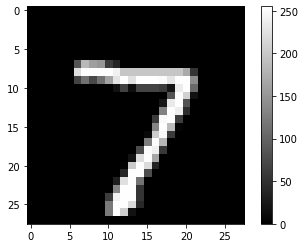

In [81]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(test_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [82]:
# NN Topology
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")
input_shape = (28, 28, 1)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape = input_shape))
model.add(lq.layers.QuantDense(128*5, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(128*2, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(64, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=64, epochs=6)

Epoch 1/6
938/938 [==============================] - 4s 3ms/step - loss: 1.2980 - accuracy: 0.8367
Epoch 2/6
938/938 [==============================] - 3s 3ms/step - loss: 0.8004 - accuracy: 0.8928
Epoch 3/6
938/938 [==============================] - 3s 3ms/step - loss: 0.6915 - accuracy: 0.9072
Epoch 4/6
938/938 [==============================] - 3s 3ms/step - loss: 0.6387 - accuracy: 0.9158
Epoch 5/6
938/938 [==============================] - 3s 3ms/step - loss: 0.5681 - accuracy: 0.9259
Epoch 6/6
938/938 [==============================] - 3s 3ms/step - loss: 0.5487 - accuracy: 0.9308


In [83]:
# Train NN
test_loss, test_acc = model.evaluate(test_images, test_labels)
lq.models.summary(model)

313/313 [==============================] - 0s 856us/step - loss: 0.8010 - accuracy: 0.9143
+sequential_8 stats--------------------------------------------------------------------+
| Layer                  Input prec.    Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                 x 1       x 1    (kB)             |
+--------------------------------------------------------------------------------------+
| flatten_8                        -  (-1, 784)        0         0       0           0 |
| quant_dense_16                   1  (-1, 640)   501760         0   61.25      501760 |
| batch_normalization_7            -  (-1, 640)        0      1280    5.00           0 |
| quant_dense_17                   1  (-1, 256)   163840         0   20.00      163840 |
| batch_normalization_8            -  (-1, 256)        0       512    2.00           0 |
| quant_dense_18                   1   (-1, 64)    16384         0    2.00       16384 |
| batch_normalizati

In [87]:
FC_TEMPLATE = """module layer_%LAYER_NUM%_fc #(
    parameter INPUT_DIM = %INPUT_DIM%,
    parameter OUTPUT_DIM = %OUTPUT_DIM%
) (
    input [INPUT_DIM-1:0] i_data,
    output reg signed [$clog2(INPUT_DIM):0] o_data [OUTPUT_DIM-1:0]
);

wire xnor_result [INPUT_DIM-1:0][OUTPUT_DIM-1:0];
reg [$clog2(INPUT_DIM):0] popcnt [OUTPUT_DIM-1:0];
reg [$clog2(INPUT_DIM):0] shift [OUTPUT_DIM-1:0];

%XNOR_GEN%

localparam CONCAT_BITS = $clog2(INPUT_DIM)-1;

always_comb begin
    for (int i = 0; i < OUTPUT_DIM; i++) begin
        popcnt[i] = 0;
        for (int j = 0; j < INPUT_DIM; j++) begin
            popcnt[i] += { {CONCAT_BITS{1'b0}}, xnor_result[j][i]};
        end
        shift[i] = popcnt[i] << 1;
        o_data[i] = shift[i] - INPUT_DIM;
    end
end

endmodule"""

BN_TEMPLATE = """module layer_%LAYER_NUM%_bn #(
    parameter INPUT_DIM = 1,
    parameter OUTPUT_DIM = 1
)(
    input signed [$clog2(INPUT_DIM):0] i_data [OUTPUT_DIM-1:0],
    output [OUTPUT_DIM-1:0] o_data
);

%COMPARE%

endmodule
"""

TOP_TEMPLATE = """module top #(
    parameter IMG_DIM = 28,
%PARAMETERS%
) (
%PORTS%
    input clk,
    input i_we,
    input [$clog2(L0_INPUT_DIM)-1:0] i_addr,
    input i_data
);

%SIGNALS%

ibuf #(
    .IMG_DIM(IMG_DIM)
) ibuf1 (
    .clk(clk),
    .i_we(i_we),
    .i_addr(i_addr),
    .i_data(i_data),
    .o_data(L0_i_data)
);

%MODULES%

endmodule"""

In [88]:
import os
import shutil
if not os.path.exists("gen_hdl"):
    os.mkdir("gen_hdl")
else:
    shutil.rmtree('gen_hdl')
    os.mkdir("gen_hdl")

def parse_fc(fc_weights, num: int):
    fc_weights[fc_weights == -1] = 0
    xnor = ""
    weight_dim = fc_weights.shape
    for input_neuron in range(weight_dim[0]):
        for output_neuron in range(weight_dim[1]):
            weight = fc_weights[input_neuron][output_neuron]
            if weight == 0:
                xnor += f"assign xnor_result[{input_neuron}][{output_neuron}] = ~i_data[{input_neuron}];\n"
            elif weight == 1:
                xnor += f"assign xnor_result[{input_neuron}][{output_neuron}] = i_data[{input_neuron}];\n"
            else:
                raise Exception(f"neuron value not 0 or 1: {input_neuron}")

    output_hdl = FC_TEMPLATE \
        .replace("%XNOR_GEN%", xnor) \
        .replace("%LAYER_NUM%", str(num)) \
        .replace("%INPUT_DIM%", str(weight_dim[0])) \
        .replace("%OUTPUT_DIM%", str(weight_dim[1]))
    with open(f"gen_hdl/L{num}_fc.v", "w") as f:
        f.write(output_hdl)
    return (weight_dim[0], weight_dim[1])

def parse_bn(beta, moving_mean, moving_variance, num: int):

    # thresholds = np.zeros(len(beta))
    print(beta.shape)
    compare = ""
    for output_neuron in range(len(beta)):
        # print(len(beta))
        threshold = moving_mean[output_neuron] - beta[output_neuron] * np.sqrt(moving_variance[output_neuron])
        compare += f"\tassign o_data[{output_neuron}] = i_data[{output_neuron}] > {round(threshold)} ? 1 : 0;\n"

    output_hdl = BN_TEMPLATE \
        .replace("%DIM_DATA%", str(len(beta))) \
        .replace("%LAYER_NUM%", str(num)) \
        .replace("%COMPARE%", compare)
        
    with open(f"gen_hdl/L{num}_bn.v", "w") as f:
        f.write(output_hdl)

In [89]:
parameters = ""
signals = ""
modules = ""
ports = ""
print(len(model.layers)-2)
n = 0
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        parse_bn(beta, moving_mean, moving_variance, n)
        signals += (
            f'wire [$clog2(L{n-1}_INPUT_DIM):0] L{n}_i_data [L{n-1}_OUTPUT_DIM-1:0];\n'
        )
        modules += (
            f'layer_{n}_bn #(\n'
            f'\t.INPUT_DIM(L{n-1}_INPUT_DIM),\n'
            f'\t.OUTPUT_DIM(L{n-1}_OUTPUT_DIM)\n'
            f') L{n}_bn (\n'
            f'\t.i_data(L{n}_i_data),\n'
            f'\t.o_data(L{n+1}_i_data)\n);\n'
        )
        n += 1
    elif isinstance(layer, lq.layers.QuantDense):
        with lq.context.quantized_scope(True):
            if n == len(model.layers)-3:
                classifier = 1
            else:
                classifier = 1
            weights = layer.get_weights()
            input_dim, output_dim = parse_fc(weights[0], n)
            parameters += (
                f'\tparameter L{n}_INPUT_DIM = {input_dim},\n'
                f'\tparameter L{n}_OUTPUT_DIM = {output_dim},\n'
                )
            signals += (
                f'wire [L{n}_INPUT_DIM-1:0] L{n}_i_data;\n'
            )
            modules += (
                f'layer_{n}_fc #(\n'
                f'\t.INPUT_DIM(L{n}_INPUT_DIM),\n'
                f'\t.OUTPUT_DIM(L{n}_OUTPUT_DIM)\n'
                f') L{n}_fc (\n'
                f'\t.i_data(L{n}_i_data),\n'
                f'\t.o_data(L{n+1}_i_data)\n);\n'
            )
            n += 1

signals += (
    f'wire [$clog2(L{n-1}_INPUT_DIM):0] L{n}_i_data [L{n-1}_OUTPUT_DIM-1:0];\n'
    f'assign o_data = L{n}_i_data;\n'
)
ports += (
    f'\toutput signed [$clog2(L{n-1}_INPUT_DIM):0] o_data [9:0],\n'
)

output_hdl = TOP_TEMPLATE \
        .replace("%PARAMETERS%", parameters.rstrip(",\n")) \
        .replace("%PORTS%", ports) \
        .replace("%SIGNALS%", signals) \
        .replace("%MODULES%", modules)

with open(f"./gen_hdl/top.v", "w") as f:
    f.write(output_hdl)

7
(640,)
(256,)
(64,)
